In [2]:
import neuromaps
from neuromaps.datasets import fetch_annotation
from neuromaps.nulls import alexander_bloch
from neuromaps.transforms import fslr_to_fslr
from neuromaps.images import load_data

import numpy as np
import pandas as pd
import dit
from dit.pid import *
from itertools import product
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

from dit.pid.pid import BasePID
from dit.pid.measures import *

In [3]:
def calcPID(d, mfMat, antiChains, measure, onlyNonzero=True):
    """
    Calculate the PID of a distribution d using the given measure. The measure must be a subclass of dit.pid.measures.measure.
    mfMat should be the precomputed matrix of Möbius function values for the antichain lattice.
    antiChains should be a list of tuples corresponding to the antichains of the lattice.
    onlyNonzero is a flag that determines whether to return only values >= 1e-5.
    """
    
    class RedundancyOnlyPID(measure):
        def __init__(self, dist, mfMat, antiChains, inputs=None, output=None, reds=None, pis=None, **kwargs):
            if output is None:
                output = dist.rvs[-1]
            if inputs is None:
                inputs = [var for var in dist.rvs if var[0] not in output]
            self._dist = dist
            self._inputs = tuple(map(tuple, inputs))
            self._output = tuple(output)
            self._kwargs = kwargs
            self._lattice = antiChains
            self._mfMat = mfMat
            self._total = None
            self._reds = {} if reds is None else reds
            self._pis = {} if pis is None else pis
            self._compute()

        def _compute(self):
            self._reds = {ac: self._measure(d, ac, self._output) for ac in self._lattice}
            self._compute_mobius_inversion()

        def _compute_mobius_inversion(self):
            atoms, reds = list(zip(*self._reds.items()))
            self._pis = dict(list(zip(atoms, np.dot(reds, self._mfMat))))
    
    r = RedundancyOnlyPID(d, mfMat, antiChains)
    if onlyNonzero:
        return {k: v for k, v in r._pis.items() if ~np.isclose(v, 0, atol=1e-5)}
    else:
        return r
    
def acStringToTuple(ac):
    return tuple([tuple([int(x) for x in block]) for block in ac.split('|')])

def acTupleToString(ac):
    return '|'.join([''.join([str(x) for x in block]) for block in ac])

In [4]:
## Set-up 1: two sources
# Download data
fc_grad = load_data(fetch_annotation(source='margulies2016', desc='fcgradient01', space='fsLR', den='32k'))
fc_lowres = load_data(np.load('neuroData/fc_lowres.pkl', allow_pickle=True))

myelin  = load_data(fetch_annotation(source='hcps1200', desc='myelinmap', space='fsLR', den='32k'))
thick   = load_data(fetch_annotation(source='hcps1200', desc='thickness', space='fsLR', den='32k'))

delta  = load_data(fetch_annotation(source='hcps1200', desc='megdelta', space='fsLR', den='4k'))
theta  = load_data(fetch_annotation(source='hcps1200', desc='megtheta', space='fsLR', den='4k'))
alpha  = load_data(fetch_annotation(source='hcps1200', desc='megalpha', space='fsLR', den='4k'))
beta   = load_data(fetch_annotation(source='hcps1200', desc='megbeta', space='fsLR', den='4k'))
gamma1 = load_data(fetch_annotation(source='hcps1200', desc='meggamma1', space='fsLR', den='4k'))
gamma2 = load_data(fetch_annotation(source='hcps1200', desc='meggamma2', space='fsLR', den='4k'))


In [5]:
def nArise(ar, n):
    # Digitize the array based on the n percentiles:
    bins = np.percentile(ar, np.linspace(0, 100, n+2))
    bins[0] = -np.inf
    bins[-1] = np.inf
    
    return np.digitize(ar, bins)-1

In [6]:
# Create a dit distribution from the three arrays of discrete observations:
def createDist(data_d):
    outcomes = list(product(*[range(data_d.max()+1) for _ in range(data_d.shape[0])]))
    dataProbs = np.unique(data_d.T, axis=0, return_counts=True)

    pmf = {out: 0 for out in outcomes}
    for i in range(dataProbs[0].shape[0]):
        pmf[tuple(dataProbs[0][i])] = dataProbs[1][i]/data_d.shape[1]

    return pmf

# 5-var PID

In [8]:
N = 5
print('loading möbius function...')
mfMat = pd.read_csv(f'antichain_outputs/antiChainLattice_mobiusFns_N={N}.csv', index_col=0)
print('done')
acs = [acStringToTuple(x) for x in (mfMat.columns)]


nDig = 1
measure = PID_MMI

print('initialising data...')
sources = [nArise(delta, nDig), nArise(theta, nDig), nArise(alpha, nDig), nArise(beta, nDig), nArise(gamma1, nDig)]
target = nArise(fc_lowres, nDig)

data = np.array([*sources[:N], target])
print('creating distribution...')
d = dit.Distribution(createDist(data))
print('calculating PID...')
r = calcPID(d, mfMat.values, acs, measure, onlyNonzero=False)
r

loading möbius function...
done
initialising data...
creating distribution...
calculating PID...


<__main__.calcPID.<locals>.RedundancyOnlyPID object at 0x176fd9c50>

In [9]:
# calculating the null distribution

# n_perm = 100
# rotated = alexander_bloch(fc_lowres, atlas='fslr', density='4k', n_perm=n_perm, seed=0)

# null_pid = []
# for i in range(n_perm):
#     if i % 10 == 0:
#         print(i)
#     target = nArise(rotated[:,i], nDig)
#     data = np.array([*sources[:N], target])
#     d = dit.Distribution(createDist(data))
#     null_pid.append(calcPID(d, mfMat.values, acs, measure, onlyNonzero=False))

# null_dict = {}
# for i in range(n_perm):
#     for k, v in null_pid[i]._pis.items():
#         if k not in null_dict:
#             null_dict[k] = []
#         null_dict[k].append(v)

# save_null_dict = {acTupleToString(k):v for k, v in null_dict.items()}
# save_null_df = pd.DataFrame.from_dict(save_null_dict).T
# save_null_df.to_csv('neuroData/PID_null_results/null_dict.csv')


In [10]:
save_null_df = pd.read_csv('neuroData/PID_null_results/null_dict.csv', index_col=0)
save_null_dict = save_null_df.T.to_dict()
save_null_dict = {k: list(v.values()) for k, v in save_null_dict.items()}

In [15]:
sig_r = {}
for k, v in r._pis.items():
    if v > np.percentile(save_null_dict[acTupleToString(k)], 95):
        sig_r[k] = v

In [16]:
def acIndexToLabel(ac):
    labDict = {'0':r'$\delta$', '1':r'$\theta$', '2':r'$\alpha$', '3':r'$\beta$', '4':r'$\gamma$', '|':')('}
    return '(' + ''.join(labDict[l] for l in ac) + ')'

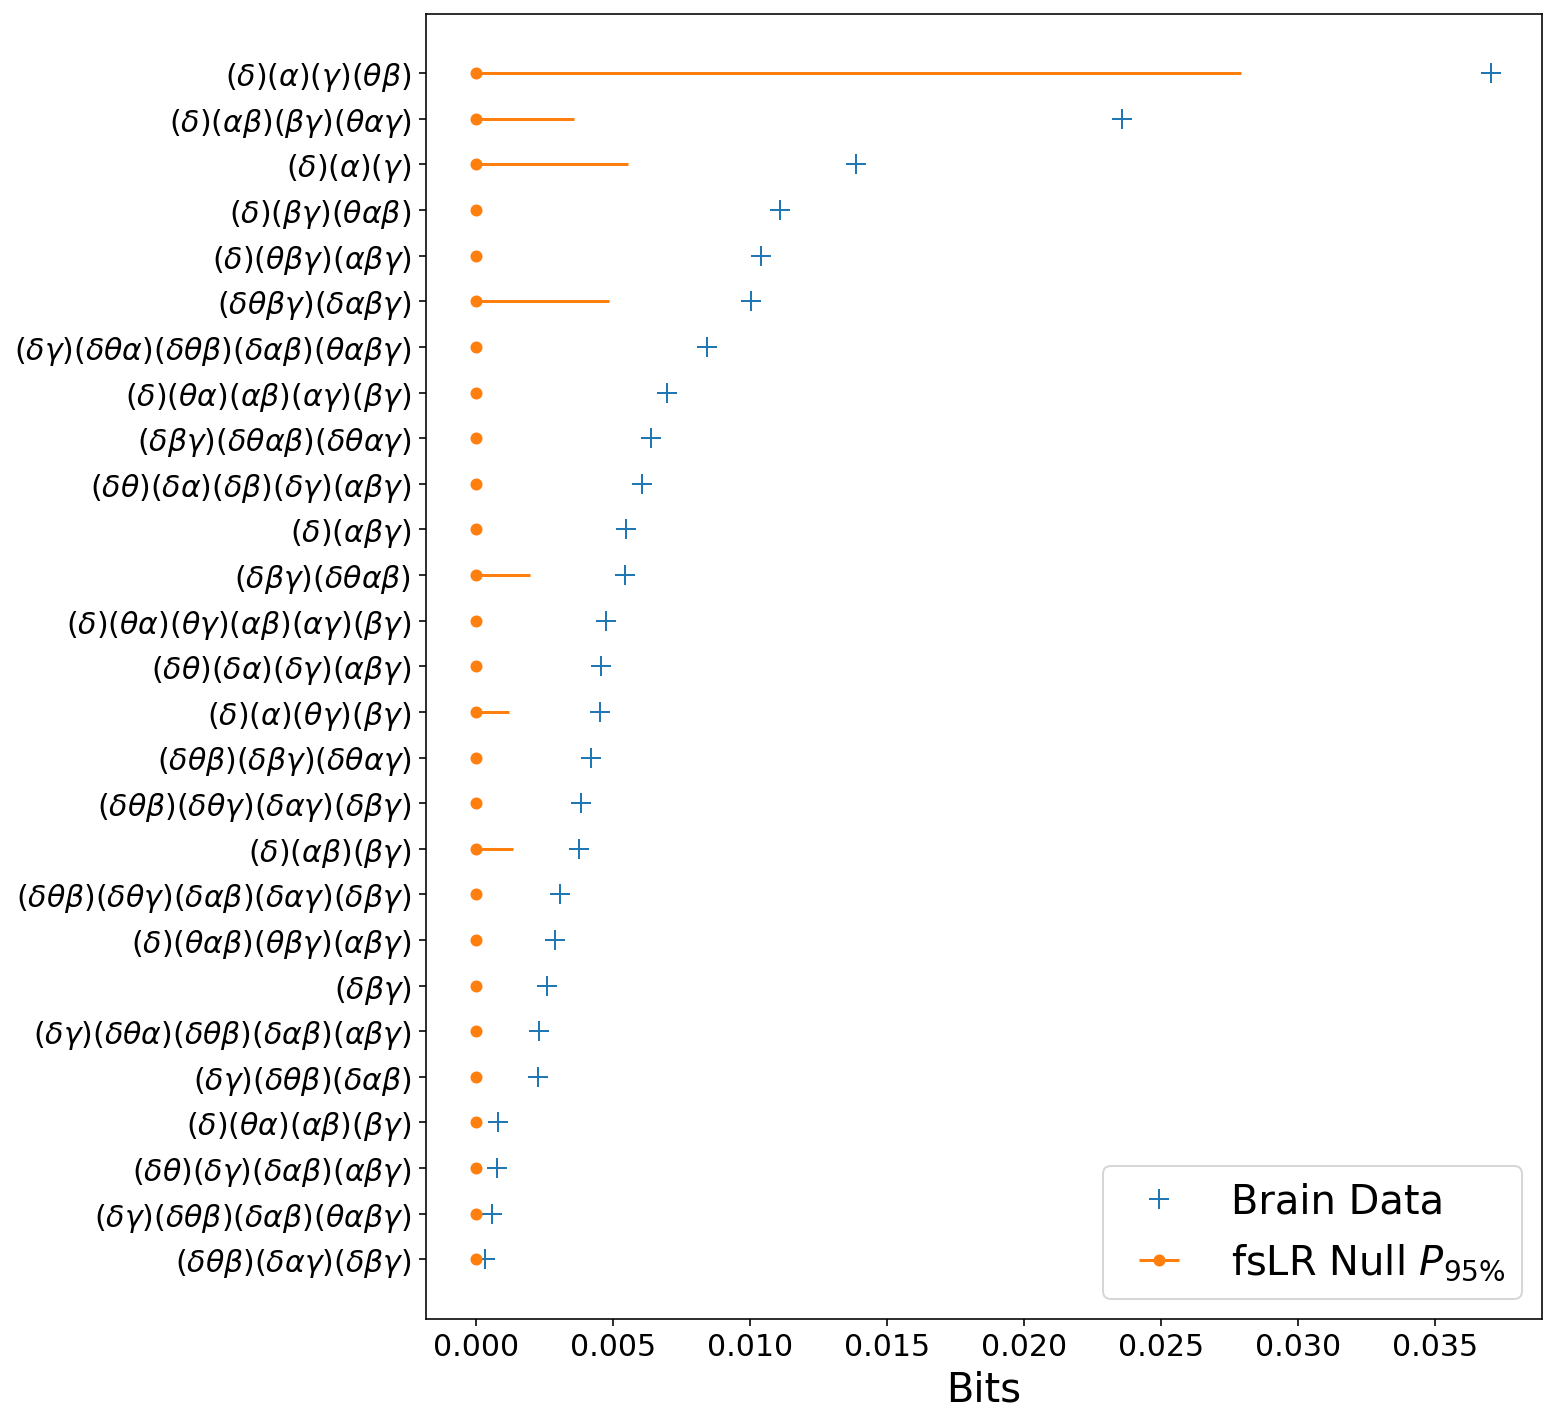

In [18]:
plt.figure(figsize=(10, 12))
toPlot = pd.DataFrame(sig_r.values(), [acTupleToString(k) for k in sig_r.keys()], columns=['Data'])
toPlot = toPlot.sort_values(by='Data', ascending=True)
# Rotate the plot by 90 degrees
a = plt.plot(toPlot.values, np.arange(len(toPlot)), '+', markersize=10, label='Brain Data')
b = plt.errorbar(x=save_null_df.loc[toPlot.index].median(axis=1), y=np.arange(len(toPlot)),
                 xerr=(np.percentile(save_null_df.loc[toPlot.index], 2.5, axis=1), np.percentile(save_null_df.loc[toPlot.index], 95, axis=1)), 
                 fmt='.', markersize=10, label=r'fsLR Null $P_{95\%}$')

plt.yticks(np.arange(len(toPlot)), labels=[acIndexToLabel(x) for x in toPlot.index], fontsize=15)
plt.xticks(fontsize=15)

plt.xlabel('Bits', fontsize=20)
# plt.ylabel('PID atoms', fontsize=20)

# plt.title('Significant information atoms among frequency bands', fontsize=20)
plt.legend(fontsize=20)

plt.show()